In [1]:
import re

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import html
import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

c:\users\jurus\desktop\machine learing lab auta\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [55]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

In [56]:
df.drop(df[(df['label'] == 1) & (df['id'] < 1080)].index, inplace = True)

In [57]:
counter1 = 0
counter0 = 0
for i in df.id:
    if df['label'][i] == 0:
        counter0 += 1
    else:
        if df['label'][i] == 1:
            counter1 += 1
print(counter1)
print(counter0)

12730
12726


In [58]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
#removes HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
#removes all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
#removes URLs
    clean = re.sub('\W+',' ', clean)                   
#replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [59]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [60]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

1        flynn hillary clinton woman campus breitbart f...
5        jackie mason hollywood love trump bomb north k...
7        benoît hamon win french socialist party presid...
8        excerpt draft script donald trump ampa black c...
9        channel plan ukraine russia courtesy trump ass...
                               ...                        
25995    bangladeshi traffic end york time dysfunction ...
25996    john kasich sign abortion ohio veto restrictiv...
25997    california today exactly sushi york time good ...
25998    marine deploy russian border norway previous m...
25999    awkward onscreen york time see series pilot ep...
Name: clean_joined, Length: 25456, dtype: object


In [71]:
df['clean_joined'][5]

'jackie mason hollywood love trump bomb north korea lack trans bathroom exclusive video breitbart try time jackie mason voice reason week exclusive clip breitbart news jackie discus loom threat north korea explain president donald trump support hollywood leave need strike decide bomb country everybody realize choice thing jackie say hollywood leave nauseous trump leave fall love minute bomb good reason jackie explain like transgender toilet jackie say surprise hollywood celebrity support trump strike syrian airfield month infuriate say save live mean save environment climate change happy people world jackie say hollywood celebs tough life country watch jackie late clip follow daniel nussbaum twitter dznussbaum'

In [61]:
#COUNT VECTORIZER - counts  the occurrence of each word for every single text in order to create a vector

from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

vectorizer = CountVectorizer()
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)


Model accuracy is :  0.800471327572663
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      2502
           1       0.89      0.69      0.78      2590

    accuracy                           0.80      5092
   macro avg       0.82      0.80      0.80      5092
weighted avg       0.82      0.80      0.80      5092



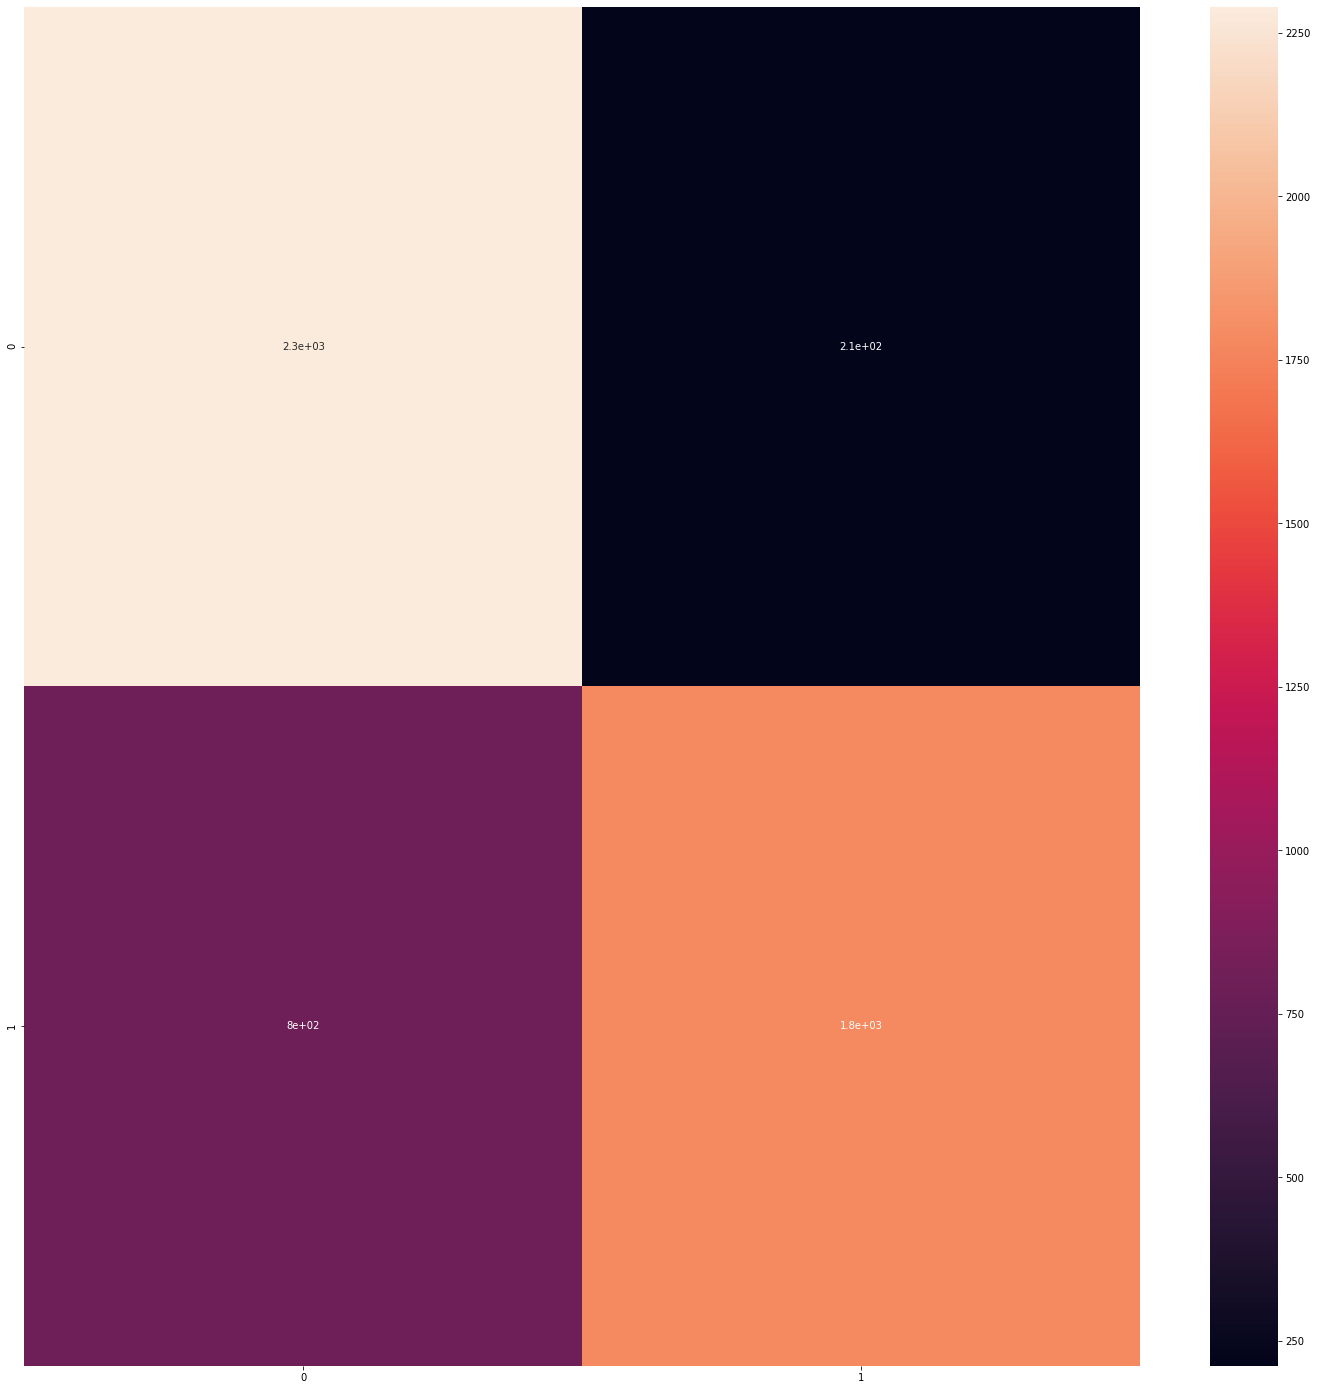

In [62]:
# NAIVE BAYES CLASSIFIER

from sklearn import naive_bayes

model = naive_bayes.MultinomialNB()
model.fit(X_train_count, y_train)

## Plot confusion matrix

pred = model.predict(X_test_count)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [63]:
df_pred = pd.DataFrame(pred, columns = ['output'])

In [64]:
for X,Y,Z in zip(pred, y_test, X_test):
    print("Model Score:", X, "\nactual score:", Y, "\ntext:", Z, "\n-----------------------") 

Model Score: 1 
actual score: 1 
text: barack obama delay suspend election hillary force email investigation economic collapse michael snyder look like hillary clinton poise election throw gamechanger friday director jam comey announce agency discover email relate hillary clinton mishandle classify information previously see accord associate press newly discover email come private server instead start go electronic device belong clinton aide huma abedin husband anthony weiner look message sexual nature weiner exchange year girl north carolina originally seize electronic device accord washington post email jointly weiner wife clinton aide huma abedin accord person knowledge inquiry accord report potentially thousand email access previously week election scandal potential possibly force clinton race happen barack obama delay suspend election replacement candidate step time friday financial market tank report clinton email wire follow come recommend early year department justice press cha

actual score: 1 
text: anti isi coalition busy defeat defeat isi jam holbrooks iraqi military force begin initial push mosul tuesday washington post report defense official 
-----------------------
Model Score: 0 
actual score: 0 
text: campaign president trump hold campaign rally york time washington extraordinarily swift return politick tumultuous month office white house wednesday say president trump hold campaign rally administration saturday rally hold airplane hangar melbourne indication trump felt isolate white house eager outside washington relive rapturous reception greet presidential campaign trump exult large crowd assemble cavernous venue spend day presidency quibble american attend inauguration wednesday joint news conference prime minister benjamin netanyahu israel trump answer question administration flirt xenophobia racism note support receive election want honor victory electoral college vote trump say tremendous enthusiasm long post twitter trump invite nearly million

text: report megyn kelly kick kardashian family interview megyn kelly gear debut sunday newsmagazine june anchor interview network kardashian family accord news star spot angeles thursday morning head studio family film anniversary special today family reportedly include khloe kourtney kardashian kylie kendall kris jenner brother kardashian absent caitlyn jenner remain york press tour source tell kelly tap interview family centerpiece anchor debut sunday news june kelly headline sunday morning news begin work month morning expect premiere late fall sunday reportedly produce dateline executive producer david corvo producer elizabeth cole york post page report month news chairman andy lack travel russia attempt obtain likely rat bonanza exclusive interview russian president vladimir putin network rumor try putin interview kelly debut establish anchor matt lauer l holt say interview kelly reportedly turn million contract offer return news tell washington post erik wemple december want gre

-----------------------
Model Score: 1 
actual score: 1 
text: eastenders get treatment super mitchell bros prev swipe leave right eastenders get treatment super mitchell bros inspire success super mario bros nintendo release eastenders play drunken crack pipe smoke phil mitchell fight albert square 
-----------------------
Model Score: 0 
actual score: 1 
text: charlottesville nuke kiloton tower shoot call badger fire april nevada test site operation upshot knothole nuclear test series 
-----------------------
Model Score: 1 
actual score: 1 
text: hillary catch hand fix foreign election word audio comment hillary catch scandal foreign implication involve try palestinian election listen casually hillary recommend determine winner palestinian election think conversation imagine unearth tape sure determine go observer report tape minute contain long relevant analysis election battle lieberman face connecticut seemingly throwaway remark election area control palestinian authority take re

Model Score: 1 
actual score: 1 
text: soneg mundo today país mundo conviene destruir para siempre manuela carmena pide madrileños guarden latas bolsas basura para hacer vestidos reyes magos mundo today radio 
-----------------------
Model Score: 1 
actual score: 1 
text: hillary screw weiner hillary screw weiner andrew anglin daily stormer october story weiner actually skype jerk session jailbait laptop wife use work daily mail report contain raunchy quote include bust tight pussy seize sure deal jailbait skype camgirls guess different state document claim import clinton email scandal know document relevant official statement pretty cagey say collusion state department thing laptop review guess miss personally hard time believe recover official story laptop damn immediately reopen investigation wait day likely opinion revolt theory theory agent freak miscarriage justice force hand comey totally bury criminality personally will bury overall detail scarce present hour go come couple day

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Model Score: 1 
actual score: 1 
text: witted australian politician try dump refugee problem trumphole monday november nazi immigration minister deny association nazi party appear international communication australia break today australian announce deal dump refugee nauru america commentator completely befuddle anti immigration election history slow uptake intellectually constipate politician think great time shove problem ask nazi morrison election miss smugly reply slip door flaccid aussie spin reporter point simply try avoid recently indict crime humanity utterly barbaric condition refugee hold nauru commentator call australian guantanamo honourable esteem minister gruffly reply know refugee terrorist trumphole pretty stupid able sneak backdoor obama tell repartitions logistics defeat pubescent opaque scheme intend past mexican wall reply surreal spin policy discus policy detail operation ongoing time expose current investigation public terrorist innocent live risk unable confirm d

Model Score: 0 
actual score: 0 
text: grandmother kill lay bare dilemma child welfare work york time girl name heaven curl asleep grandmother mattress share live room floor woman carmen irizarry legal guardian year girl trouble mother heaven protector sick breathe oxygen tank long hospital stay acute lung disease early morning quiet apartment south bronx henry maldonado irizarry companion year enter room clutch chef knife police say fury thrust knife heaven irizarry forth blade cut time heaven torso leave grandmother try block blow heaven say irizarry word granddaughter girl tell police likely save join grim tally child kill people close city see murder rat fall historic low death remain stubborn strain violence expose lapse child welfare notorious case caseworker miss persistent sign physical abuse child late die incite outrage prompt reform sign heaven irizarry case subtle home typical trouble household child welfare worker encounter love solid guardian surround people addict drug e

text: john podesta tell cheryl mill dump email news clinton private email server break trend article trend article john podesta tell cheryl mill dump email news clinton private email server break source syrmopoulos washington prove proverbial nail coffin hillary clinton presidential ambition email release wikileaks morning batch email clinton campaign chair john podesta reveal potential criminal intent violate court order subpoena document john podesta send message hour york time report clinton violate federal record requirement server accord late batch podesta email release wikileaks email question send podesta march reveal clinton campaign chair direct cheryl mill hillary attorney chief staff destroy email subpoena email exchange podesta mill come suspiciously news break clinton private email server news clinton private email server public podesta write mill sound like lanny go dump email good sooner late podesta tell mill mill respond think nick rocket scientist figure exactly podes

Model Score: 0 
actual score: 0 
text: france recipe squabble marseille soap york time marseille soap savon marseille french wine cheese history date middle age frenchwoman swear crude square block natural skin cleanser pinch toothpaste substitute moth repellent recent year cheap chinese turkish knockoff flood market soapmakers marseille rally protect product reputation band recently french government grant label authenticity distinguish genuine stuff imitator trouble begin original marseille soap specific recipe consider sacred louis protect royal edict battle erupt soapmaking faction exactly modern rule constitute true marseille soap soapmasters base mainly mediterranean port give soap label authenticity product strictly original louis recipe process involve heat soda seawater olive large caldron day cool open pit finish soap odorless group large company include occitane global chain retailer body fragrance product want government certify recipe allow cheap vegetable oil additive per

Model Score: 1 
actual score: 1 
text: isi thug horrify body dead comrade trap kurd oncoming humvee isi think take christian village look terrify surprise watch video right forewarn contain graphic content unclear point body strap hood serve warn rest fellow islamic radical merely trophy serve encouragement kurdish fighter regardless clear sign bloody battle retake mosul underway earnest battle certainly result incredible bloodshed loss life side possible kurd deliberately choose strap dead body foe hood vehicle islamic state group thug consider jihadist tactic dead kurdish fighter capture yazidi slave long serve purpose sadistic brutal utterly atrocious 
-----------------------
Model Score: 0 
actual score: 0 
text: decade boom boom room suit bias persist woman york time year smith barney sexually assault work lisa may say tremble tell story early morning walnut creek calif branch broke person build follow may office back corner know lift skirt tights beg stop recall interview assault

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [65]:
# Frequency of the words in a vectorizer
sum_words = X_train_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [66]:
print(words_freq)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
print(vectorizer.get_feature_names())

['a_merrill', 'a_s_sinated', 'aaa', 'aaaaah', 'aaaaggg', 'aaaahhh', 'aaah', 'aaahhh', 'aaajiao', 'aaany', 'aaargh', 'aabb', 'aach', 'aachen', 'aadara', 'aadhar', 'aadmi', 'aadvantage', 'aaeeb', 'aafe', 'aah', 'aahhh', 'aaib', 'aaidh', 'aaii', 'aaima', 'aaingr', 'aaja', 'aakar', 'aakash', 'aakhri', 'aakre', 'aalborg', 'aali', 'aaliya', 'aaliyah', 'aall', 'aalto', 'aaluijqn', 'aamaq', 'aamer', 'aamon', 'aand', 'aangeklaagd', 'aangenomen', 'aangezien', 'aankhen', 'aankomst', 'aankondigde', 'aankondiging', 'aannemen', 'aanstaande', 'aantreden', 'aanval', 'aanwezigheid', 'aanzien', 'aaojejptcy', 'aapke', 'aapko', 'aapl', 'aapne', 'aaps', 'aapse', 'aardbevingen', 'aarde', 'aardvark', 'aargau', 'aargauer', 'aargh', 'aarhus', 'aarizonian', 'aaroe', 'aaron', 'aaronkleinshow', 'aarp', 'aarón', 'aashiq', 'aashton', 'aasif', 'aata', 'aaup', 'aauw', 'aaye', 'aayush', 'aba', 'abaaoud', 'ababa', 'aback', 'abacus', 'abad', 'abadam', 'abadgaran', 'abadi', 'abady', 'abagi', 'abaja', 'abajo', 'abakumov',

In [68]:
neg_class_prob_sorted = model.feature_log_prob_[0, :].argsort()[::-1]

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:200]))

['say' 'trump' 'time' 'state' 'year' 'people' 'like' 'president' 'go'
 'american' 'work' 'york' 'know' 'come' 'think' 'unite' 'country'
 'clinton' 'government' 'want' 'tell' 'include' 'take' 'house' 'news'
 'report' 'official' 'company' 'obama' 'republican' 'call' 'good' 'right'
 'woman' 'campaign' 'group' 'leave' 'world' 'white' 'city' 'week' 'late'
 'million' 'look' 'long' 'live' 'help' 'percent' 'party' 'write' 'need'
 'national' 'plan' 'vote' 'political' 'change' 'police' 'case' 'month'
 'election' 'family' 'thing' 'attack' 'support' 'accord' 'public' 'member'
 'give' 'medium' 'policy' 'force' 'add' 'begin' 'administration' 'home'
 'court' 'donald' 'issue' 'breitbart' 'point' 'question' 'follow' 'school'
 'security' 'ask' 'start' 'twitter' 'child' 'place' 'federal' 'play'
 'leader' 'high' 'department' 'office' 'russia' 'early' 'continue' 'hold'
 'order' 'build' 'great' 'turn' 'washington' 'try' 'life' 'make' 'team'
 'democrat' 'open' 'talk' 'business' 'america' 'kill' 'executive' '

In [69]:
pos_class_prob_sorted = model.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:200]))

['trump' 'clinton' 'say' 'people' 'state' 'hillary' 'time' 'year'
 'american' 'like' 'election' 'know' 'president' 'world' 'government' 'go'
 'come' 'vote' 'report' 'email' 'right' 'country' 'work' 'obama' 'think'
 'medium' 'news' 'campaign' 'russia' 'want' 'tell' 'good' 'need' 'donald'
 'take' 'america' 'support' 'live' 'post' 'thing' 'leave' 'political'
 'include' 'call' 'white' 'unite' 'force' 'look' 'change' 'russian'
 'woman' 'long' 'power' 'house' 'party' 'million' 'group' 'help' 'accord'
 'policy' 'write' 'point' 'follow' 'give' 'public' 'mean' 'military'
 'fact' 'believe' 'high' 'national' 'continue' 'october' 'police'
 'republican' 'case' 'attack' 'child' 'late' 'syria' 'great' 'video'
 'happen' 'plan' 'life' 'place' 'official' 'nation' 'issue' 'result'
 'control' 'share' 'source' 'comment' 'investigation' 'black' 'claim'
 'presidential' 'order' 'money' 'washington' 'article' 'november' 'week'
 'today' 'voter' 'information' 'candidate' 'make' 'begin' 'start' 'free'
 'human' 'h